In [1]:
import pandas as pd

# 从Excel文件加载预处理后的数据
data = pd.read_excel('预处理后的数据.xlsx')

# 查看数据的前几行，确保数据加载正确
print(data.head())

   ID  Customer_care_calls  Customer_rating  Cost_of_the_Product  \
0   1                    4                2                  177   
1   2                    4                5                  216   
2   3                    2                2                  183   
3   4                    3                3                  176   
4   5                    2                2                  184   

   Prior_purchases  Discount_offered  Weight_in_gms  Reached.on.Time_Y.N  \
0                3                44           1233                    1   
1                2                59           3088                    1   
2                4                48           3374                    1   
3                4                10           1177                    1   
4                3                46           2484                    1   

   Warehouse_block_B  Warehouse_block_C  Warehouse_block_D  Warehouse_block_F  \
0                  0                  0              

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# 数据探索
print(data.describe())

# 添加日期列（假设数据按时间顺序排列）
data['Date'] = pd.date_range(start='2020-01-01', periods=len(data), freq='D')
data.set_index('Date', inplace=True)

# 绘制历史销售趋势图
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Prior_purchases'], label='Prior Purchases')
plt.title('Historical Sales Trend')
plt.xlabel('Date')
plt.ylabel('Number of Prior Purchases')
plt.legend()
plt.show()

# 季节性分析
data['Month'] = data.index.month
seasonal_data = data.groupby('Month')['Prior_purchases'].mean()

plt.figure(figsize=(10, 6))
seasonal_data.plot(kind='bar')
plt.title('Seasonal Demand Analysis')
plt.xlabel('Month')
plt.ylabel('Average Prior Purchases')
plt.show()

                ID  Customer_care_calls  Customer_rating  Cost_of_the_Product  \
count  10999.00000         10999.000000     10999.000000         10999.000000   
mean    5500.00000             4.054459         2.990545           210.196836   
std     3175.28214             1.141490         1.413603            48.063272   
min        1.00000             2.000000         1.000000            96.000000   
25%     2750.50000             3.000000         2.000000           169.000000   
50%     5500.00000             4.000000         3.000000           214.000000   
75%     8249.50000             5.000000         4.000000           251.000000   
max    10999.00000             7.000000         5.000000           310.000000   

       Prior_purchases  Discount_offered  Weight_in_gms  Reached.on.Time_Y.N  \
count     10999.000000      10999.000000   10999.000000         10999.000000   
mean          3.567597         13.373216    3634.016729             0.596691   
std           1.522860        

<Figure size 1200x600 with 1 Axes>

<Figure size 1000x600 with 1 Axes>

D:\Anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


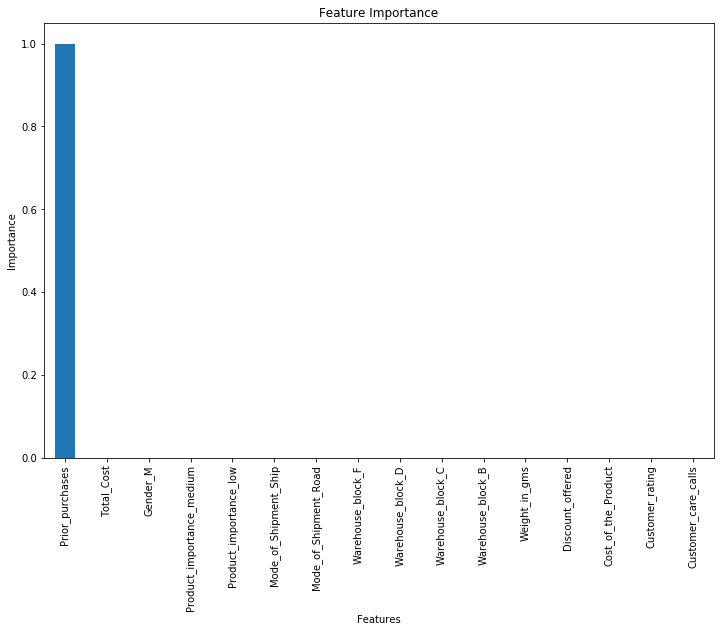

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# 定义特征和目标变量
features = ['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases',
            'Discount_offered', 'Weight_in_gms', 'Warehouse_block_B', 'Warehouse_block_C',
            'Warehouse_block_D', 'Warehouse_block_F', 'Mode_of_Shipment_Road', 'Mode_of_Shipment_Ship',
            'Product_importance_low', 'Product_importance_medium', 'Gender_M', 'Total_Cost']
target = 'Prior_purchases'

X = data[features]
y = data[target]

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 训练随机森林模型
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 特征重要性分析
feature_importances = pd.Series(rf_model.feature_importances_, index=features)
feature_importances = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(12, 8))
feature_importances.plot(kind='bar')
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [4]:
!pip install statsmodels

twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
You are using pip version 10.0.1, however version 24.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


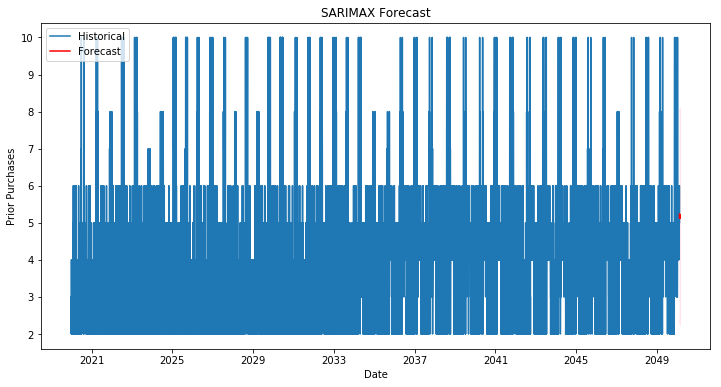

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 加载预处理后的数据
data = pd.read_excel('预处理后的数据.xlsx')

# 确保数据中有一个日期列（假设列名为 'Date'），并且目标列（假设列名为 'Prior_purchases'）
# 如果没有日期列，可以手动创建一个
if 'Date' not in data.columns:
    # 显式指定频率为每天（D）
    data['Date'] = pd.date_range(start='2020-01-01', periods=len(data), freq='D')

# 将日期列设置为索引，并确保频率信息被保留
data.set_index('Date', inplace=True)
data = data.asfreq('D')  # 显式指定频率为每天

# 选择时间序列分析的目标列
ts_data = data['Prior_purchases']

# 拟合 SARIMAX 模型
# 参数说明：
# (1, 1, 1)：ARIMA 部分的参数，分别表示自回归项、差分阶数和移动平均项
# seasonal_order=(1, 1, 1, 12)：季节性部分的参数，表示季节性自回归项、季节性差分阶数、季节性移动平均项和季节性周期
model = SARIMAX(ts_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit(disp=False)

# 预测未来10天的需求
forecast = model_fit.get_forecast(steps=10)
forecast_index = pd.date_range(start=ts_data.index[-1], periods=11, freq='D')[1:]
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# 绘制预测结果
plt.figure(figsize=(12, 6))
plt.plot(ts_data.index, ts_data, label='Historical')
plt.plot(forecast_index, forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('SARIMAX Forecast')
plt.xlabel('Date')
plt.ylabel('Prior Purchases')
plt.legend()
plt.show()

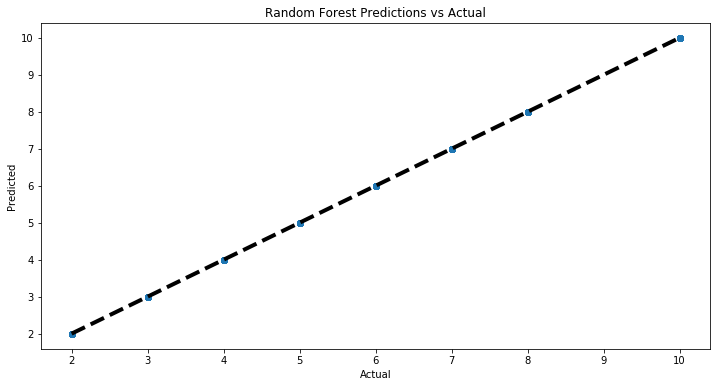

Random Forest MSE: 0.0


In [6]:
from sklearn.metrics import mean_squared_error

# 使用随机森林模型进行预测
rf_predictions = rf_model.predict(X_test)

# 绘制预测结果与实际值的对比图
plt.figure(figsize=(12, 6))
plt.scatter(y_test, rf_predictions)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.title('Random Forest Predictions vs Actual')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

# 模型评估
rf_mse = mean_squared_error(y_test, rf_predictions)
print(f'Random Forest MSE: {rf_mse}')

D:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
D:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
D:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


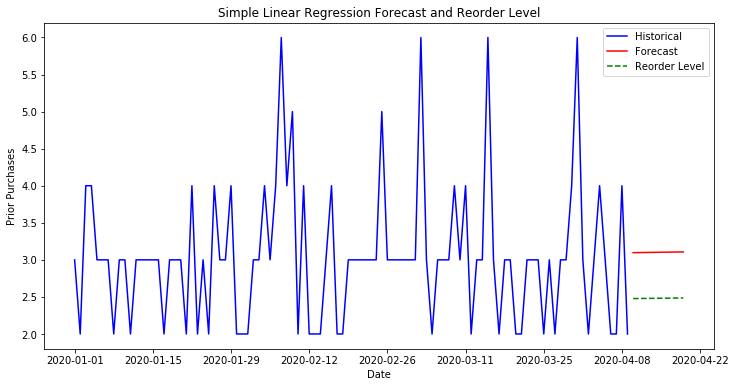

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 加载预处理后的数据
data = pd.read_excel('预处理后的数据.xlsx')

# 确保数据中有一个日期列（假设列名为 'Date'），并且目标列（假设列名为 'Prior_purchases'）
# 如果没有日期列，可以手动创建一个
if 'Date' not in data.columns:
    data['Date'] = pd.date_range(start='2020-01-01', periods=len(data), freq='D')

# 将日期列设置为索引
data.set_index('Date', inplace=True)

# 选择时间序列分析的目标列
ts_data = data['Prior_purchases']

# 删除缺失值
ts_data = ts_data.dropna()

# 使用数据的前100条进行测试（可选）
ts_data = ts_data.iloc[:100]

# 将时间索引转换为整数序列
time_index = np.arange(len(ts_data))
values = ts_data.values

# 手动计算线性回归的斜率和截距
# y = mx + b
m, b = np.polyfit(time_index, values, 1)

# 预测未来值
future_steps = 10
future_index = np.arange(len(ts_data), len(ts_data) + future_steps)
forecast = m * future_index + b

# 假设补货策略是基于预测需求的80%
reorder_level = forecast * 0.8

# 绘制预测结果和补货策略
plt.figure(figsize=(12, 6))
plt.plot(ts_data.index, ts_data, label='Historical', color='blue')
plt.plot(pd.date_range(start=ts_data.index[-1], periods=future_steps + 1, freq='D')[1:], forecast, label='Forecast', color='red')
plt.plot(pd.date_range(start=ts_data.index[-1], periods=future_steps + 1, freq='D')[1:], reorder_level, label='Reorder Level', color='green', linestyle='--')
plt.title('Simple Linear Regression Forecast and Reorder Level')
plt.xlabel('Date')
plt.ylabel('Prior Purchases')
plt.legend()
plt.show()

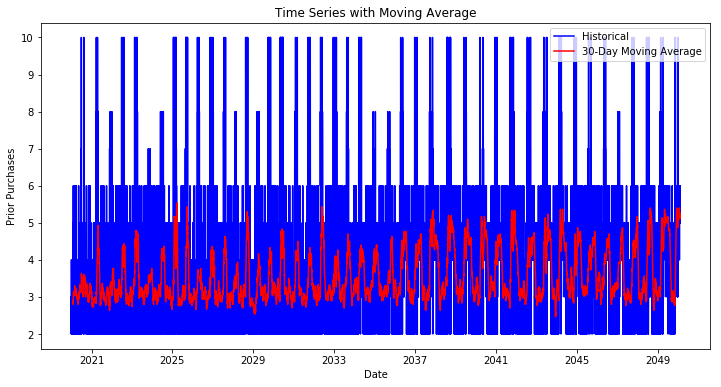

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# 加载预处理后的数据
data = pd.read_excel('预处理后的数据.xlsx')

# 确保数据中有一个日期列（假设列名为 'Date'），并且目标列（假设列名为 'Prior_purchases'）
if 'Date' not in data.columns:
    data['Date'] = pd.date_range(start='2020-01-01', periods=len(data), freq='D')

# 将日期列设置为索引
data.set_index('Date', inplace=True)

# 选择时间序列分析的目标列
ts_data = data['Prior_purchases']

# 计算移动平均线，窗口大小为30天
moving_avg = ts_data.rolling(window=30).mean()

# 绘制原始数据和移动平均线
plt.figure(figsize=(12, 6))
plt.plot(ts_data, label='Historical', color='blue')
plt.plot(moving_avg, label='30-Day Moving Average', color='red')
plt.title('Time Series with Moving Average')
plt.xlabel('Date')
plt.ylabel('Prior Purchases')
plt.legend()
plt.show()